In [66]:
import cv2
import os
from matplotlib import pyplot as plt

import numpy as np
import xml.etree.ElementTree as ET
from pathlib import Path
import pandas as pd

dataDir = Path('../dataset/images') 
annotationsDir = Path('../dataset/annotations')

img = cv2.imread(os.path.join(dataDir, 'road494.png'))

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [67]:
# Classification setup

def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(dataDir) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [68]:
df_train = generate_train_df(annotationsDir)
print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,../dataset/images/road712.png,300,400,speedlimit,98,140,139,182
1,../dataset/images/road706.png,300,400,speedlimit,136,92,177,135
2,../dataset/images/road289.png,300,400,stop,61,140,146,227
3,../dataset/images/road538.png,300,400,speedlimit,115,169,149,205
4,../dataset/images/road510.png,300,400,speedlimit,89,201,133,245


In [69]:
# Image Pre-processing

# Improve Lighting

def improve_lighting(img):
    
    imgYUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    imgYUV[:, :, 0] = cv2.equalizeHist(imgYUV[:, :, 0])
    imgBetterLighting = cv2.cvtColor(imgYUV, cv2.COLOR_YUV2BGR)

    return imgBetterLighting

# Smooth

def smoothing(img):
    
    imgWithMedianFilter = cv2.medianBlur(img, 5)

    return imgWithMedianFilter

imgBetter = improve_lighting(img)
imgSmooth = smoothing(imgBetter)


In [70]:
def bgr_to_hsv(img):
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img_hsv

imghsv = bgr_to_hsv(imgSmooth)

In [71]:
# Image Segmentation

def image_segmentation(img):
    #set the bounds for the red hue
    lower_red_n1 = np.array([0,70,60])
    upper_red_n1 = np.array([10,255,255])

    lower_red_n2 = np.array([170,70,60])
    upper_red_n2 = np.array([180,255,255])

    lower_blue_n3 = np.array([78,158,124])
    upper_blue_n3 = np.array([138,255,255])

    #create a mask using the bounds set
    mask_1 = cv2.inRange(img, lower_red_n1, upper_red_n1)
    mask_2 = cv2.inRange(img, lower_red_n2, upper_red_n2)

    mask_red = mask_1 + mask_2

    mask_blue = cv2.inRange(img, lower_blue_n3, upper_blue_n3)

    img_red = cv2.cvtColor(mask_red, cv2.COLOR_BGR2RGB)
    img_blue = cv2.cvtColor(mask_blue, cv2.COLOR_BGR2RGB)

    return img_blue, img_red

img_blue, img_red = image_segmentation(imghsv)

In [72]:
# Image Thresholding and Morphological Operations

def morphological_ops(img_blue, img_red):
    # Red
    imgGray_red = cv2.cvtColor(img_red, cv2.COLOR_RGB2GRAY)
    ret, thresh_red = cv2.threshold(imgGray_red, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Removing Noise
    kernel = np.ones((3, 3),np.uint8)
    opening = cv2.morphologyEx(thresh_red, cv2.MORPH_OPEN, kernel, iterations = 2)

    # Getting the background area
    processed_red = cv2.dilate(opening,kernel,iterations=5)
    processed_red = cv2.erode(processed_red,kernel,iterations=1)

    # Blue
    imgGray_blue = cv2.cvtColor(img_blue, cv2.COLOR_RGB2GRAY)
    ret, thresh_blue = cv2.threshold(imgGray_blue, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Removing Noise
    kernel = np.ones((5, 5),np.uint8)
    opening = cv2.morphologyEx(thresh_blue, cv2.MORPH_OPEN, kernel, iterations = 2)

    # Getting the background area
    processed_blue = cv2.erode(opening,kernel,iterations=1)
    processed_blue = cv2.dilate(opening,kernel,iterations=1)

    return processed_blue, processed_red

processed_blue, processed_red = morphological_ops(img_blue, img_red)

Found red circle sign
Found red circle sign


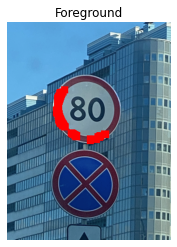

In [73]:
# Shape Recognition

def shape_recognition(processed_red, processed_blue):
    # Red
    debug = "red"

    # Octagon Detection
    contours_red, hierarchy_red = cv2.findContours(processed_red, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours_red:
        approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
        #print(len(approx))

        if len(approx) == 8:
            print('Found STOP sign')
            img_red_contours = cv2.drawContours(img, [cnt], 0, (0,0,255), -1)

        elif len(approx) >= 12:
            print('Found red circle sign')
            img_red_contours = cv2.drawContours(img, [cnt], 0, (0,0,255), -1)

    # Apply the Hough circle transform
    #detectionMethod = cv2.HOUGH_GRADIENT # corresponds to the canny filter
    #resolutionFlag = 1 # same resolution as the original image
    #minDistance = 20 # between the centers of the detected circles

    # Convert to grayscale

    #gray_red = cv2.cvtColor(processed_red, cv2.COLOR_GRAY2RGB)

    # param1 and param2 are the thresholds passed to the detection method 
    #img_red_circles = cv2.HoughCircles(imgGray_red, detectionMethod, resolutionFlag, minDistance, param1=200, param2=100, minRadius=0, maxRadius=0)
    #img_red_circles = np.uint16(np.around(img_red_circles))

    # Drawing the resulting circles
    #for i in img_red_circles[0,:]: 
    #    cv2.circle(imgGray_red,(i[0],i[1]),i[2],(0,255,0),2)

    #plt.imshow(imgGray_red)
    #plt.title('Hough Circle Transform Result')
    #plt.axis('off')
    #plt.show()

    # Blue

    contours_blue, hierarchy_blue = cv2.findContours(processed_blue, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours_blue:
        approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
        #print(len(approx))

        if len(approx) == 4:
            print('Found BLUE sign')
            debug = "blue"
            img_blue_contours = cv2.drawContours(img, [cnt], 0, (255,0,0), -1)

    if debug=="red":
        plt.imshow(cv2.cvtColor(img_red_contours, cv2.COLOR_BGR2RGB))
        plt.title('Foreground')
        plt.axis('off')
        plt.show()
    elif debug == "blue":
        plt.imshow(cv2.cvtColor(img_blue_contours, cv2.COLOR_BGR2RGB))
        plt.title('Foreground')
        plt.axis('off')
        plt.show()
    
    return processed_red, processed_blue

img_red_contours, img_blue_contours = shape_recognition(processed_red, processed_blue)


In [75]:
# Classification train
cnt = 1


for index, row in df_train.iterrows():
    

    cnt = cnt + 1
    if cnt > 5:
        break

speedlimit
speedlimit
stop
speedlimit
speedlimit
